In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import read_parquet
from tqdm import tqdm
%matplotlib inline

In [60]:
# decals_pred = pd.read_table("/data/renhaoye/decals_2022/out_decals_pred.txt", sep="\s+")
# decals_pred['ra'] = "N"
# decals_pred['dec'] = "N"
# for i in tqdm(range(len(decals_pred))):
# # for i in tqdm(range(50)):
#     decals_pred.loc[i, 'ra'] = str(decals_pred.loc[i, 'loc']).split("_")[0]
#     decals_pred.loc[i, 'dec'] = str(decals_pred.loc[i, 'loc']).split("_")[1]
# decals_pred.to_csv("/data/renhaoye/decals_2022/pred_out_decals_0519.csv")
decals_pred = pd.read_csv("/data/renhaoye/decals_2022/pred_out_decals_0519.csv", index_col=0)

In [61]:
from astropy.io import fits
from tqdm import tqdm
with fits.open("/data/renhaoye/decals_2022/MGS_out_DECaLS.fits") as hdul:
    data = np.array(hdul[1].data)
    out = np.zeros((data.shape[0],10))
    # [('VID', '>i4'), ('RA', '>f8'), ('DEC', '>f8'), ('PETROMAG', '>f8', (5,)), ('MODELMAG', '>f8', (5,)), ('FIBERMAG', '>f8', (5,)), ('VAGC_SELECT', '>i4'), ('KCORRECT', '>f8', (5,)), ('Z', '>f8'), ('ZFLAG', '>f8')]
    for i in tqdm(range(data.shape[0])):
        out[i,0] = data[i]["VID"]
        out[i,1] = data[i]["RA"]
        out[i,2] = data[i]["DEC"]
        out[i,3] = data[i]["PETROMAG"][3]
        out[i,4] = data[i]["MODELMAG"][3]
        out[i,5] = data[i]["FIBERMAG"][3]
        out[i,6] = data[i]["VAGC_SELECT"]
        out[i,7] = data[i]["KCORRECT"][3]
        out[i,8] = data[i]["Z"]
        out[i,9] = data[i]["ZFLAG"]
out = pd.DataFrame(out, columns=["VID","ra","dec","petro_mag","model_mag","fiber_mag","vagc_select","k_correct", "z", "z_flag"])

100%|████████████████████████████████████████████| 476890/476890 [00:06<00:00, 73152.84it/s]


In [62]:
out = out.round({"ra": 6, "dec": 6})
decals_pred = decals_pred.round({"ra": 6, "dec": 6})

In [63]:
concat = pd.merge(decals_pred, out, how="inner", on=["ra", "dec"])

In [77]:
cut = concat.query("z < 0.35")

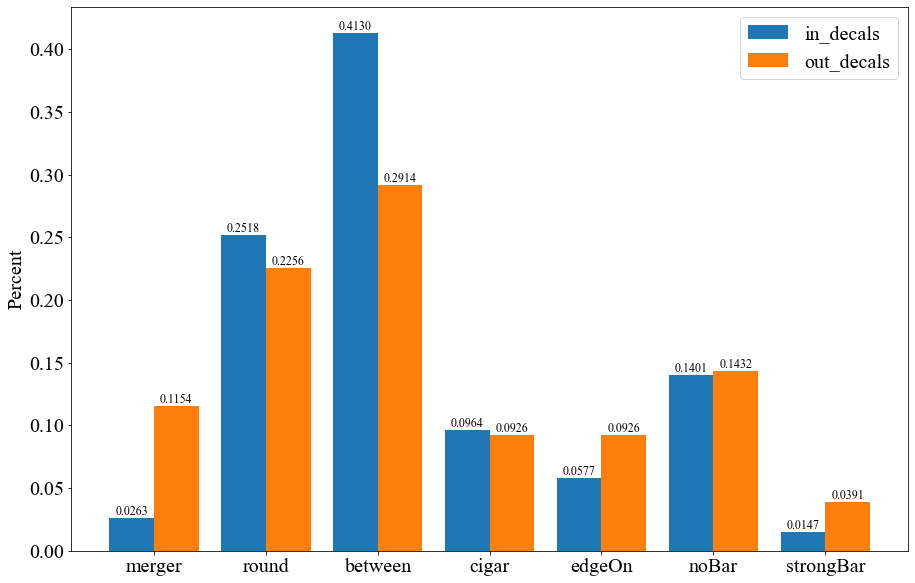

In [78]:
merger = cut.query("label == 0")
round = cut.query("label == 1")
between = cut.query("label == 2")
cigar = cut.query("label == 3")
edgeOn = cut.query("label == 4")
noBar = cut.query("label == 5")
strongBar = cut.query("label == 6")
idx = np.arange(0, 7, 1)
num_out = [len(merger), len(round), len(between), len(cigar), len(cigar), len(noBar), len(strongBar)]
num_in={"merger":7241, "round":69334, "between":113733, "cigar":26547, "edgeOn":15900, "noBar":38575, "strongBar":4041}
sum_out, sum_in = 0, 7241 + 69334 + 113733 + 26547 + 15900 + 38575 + 4041
for i in num_out:
    sum_out += i
percent_in_decals = [x/sum_in for x in list(num_in.values())]
percent_out_decals = [x/sum_out for x in num_out]
labels = list(num_in.keys())
width = 0.4
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(x - width/2, percent_in_decals, width, label='in_decals')
rects2 = ax.bar(x + width/2, percent_out_decals, width, label='out_decals')
ax.set_ylabel('Percent', fontsize=20)
# ax.set_title('percent of in/out decals prediction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
for a,b in zip(x,percent_in_decals): ##控制标签位置
    plt.text(a-width/2,b,'%.4f'%b,ha = 'center',va = 'bottom',fontsize=12)
for a,b in zip(x,percent_out_decals): ##控制标签位置
    plt.text(a+width/2,b,'%.4f'%b,ha = 'center',va = 'bottom',fontsize=12)
ax.legend(fontsize=20)
# plt.xlabel("class", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [32]:
in_decals = pd.read_csv("/data/renhaoye/decals_2022/dataset_decals.csv", index_col=0)

In [38]:
merger_in = in_decals.query("label == 0")
round_in = in_decals.query("label == 1")
between_in = in_decals.query("label == 2")
cigar_in = in_decals.query("label == 3")
edgeOn_in = in_decals.query("label == 4")
noBar_in = in_decals.query("label == 5")
strongBar_in = in_decals.query("label == 6")

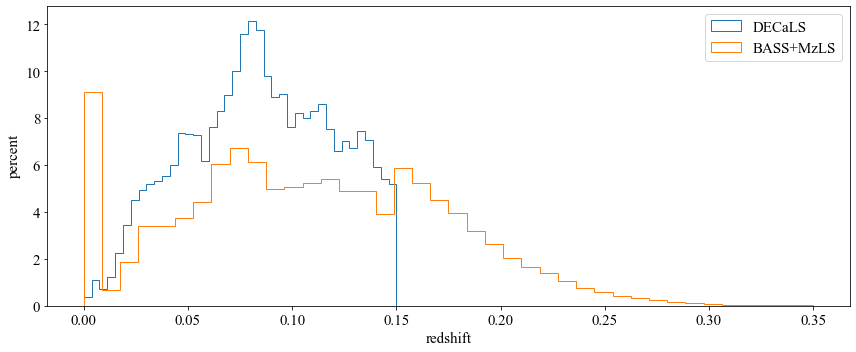

In [57]:
plt.rc('font',family='Times New Roman')
plt.figure(figsize=(12, 5))
plt.hist(in_decals.redshift, range=(1e-5, 0.15), histtype="step", label = "DECaLS", bins=40, density=True)
plt.hist(concat.z, histtype="step", range=(0, 0.35), label = "BASS+MzLS", bins=40, density=True)
plt.xlabel("redshift", fontsize=15)
plt.ylabel("percent", fontsize=15)
plt.legend(loc="best", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

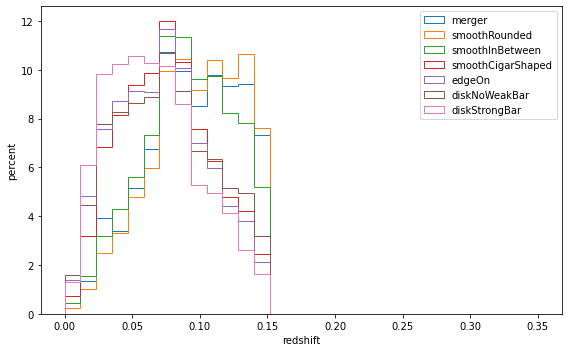

In [41]:
plt.figure(figsize=(8, 5))
plt.hist(merger_in.redshift,range=(1e-5,0.35), histtype="step", label = "merger", bins=30,density=True)
plt.hist(round_in.redshift,range=(1e-5,0.35), histtype="step", label = "smoothRounded", bins=30,density=True)
plt.hist(between_in.redshift,range=(1e-5,0.35), histtype="step", label = "smoothInBetween", bins=30,density=True)
plt.hist(cigar_in.redshift,range=(1e-5,0.35), histtype="step", label = "smoothCigarShaped", bins=30,density=True)
plt.hist(edgeOn_in.redshift,range=(1e-5,0.35), histtype="step", label = "edgeOn", bins=30,density=True)
plt.hist(noBar_in.redshift,range=(1e-5,0.35), histtype="step", label = "diskNoWeakBar", bins=30,density=True)
plt.hist(strongBar_in.redshift,range=(1e-5,0.35), histtype="step", label = "diskStrongBar", bins=30,density=True)
plt.xlabel("redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

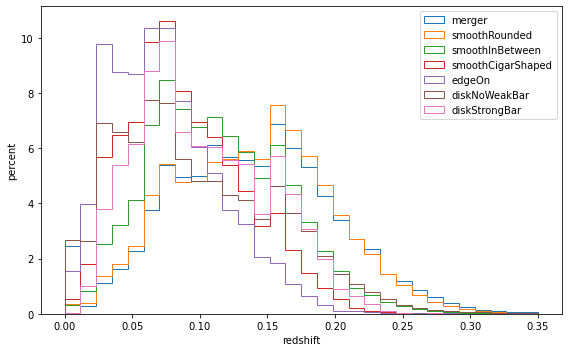

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(merger_out.z,range=(1e-5,0.35), histtype="step", label = "merger", bins=30,density=True)
plt.hist(smoothRounded_out.z,range=(1e-5,0.35), histtype="step", label = "smoothRounded", bins=30,density=True)
plt.hist(smoothInBetween_out.z,range=(1e-5,0.35), histtype="step", label = "smoothInBetween", bins=30,density=True)
plt.hist(smoothCigarShaped_out.z,range=(1e-5,0.35), histtype="step", label = "smoothCigarShaped", bins=30,density=True)
plt.hist(edgeOn_out.z,range=(1e-5,0.35), histtype="step", label = "edgeOn", bins=30,density=True)
plt.hist(diskNoWeakBar_out.z,range=(1e-5,0.35), histtype="step", label = "diskNoWeakBar", bins=30,density=True)
plt.hist(diskStrongBar_out.z,range=(1e-5,0.35), histtype="step", label = "diskStrongBar", bins=30,density=True)
plt.xlabel("redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

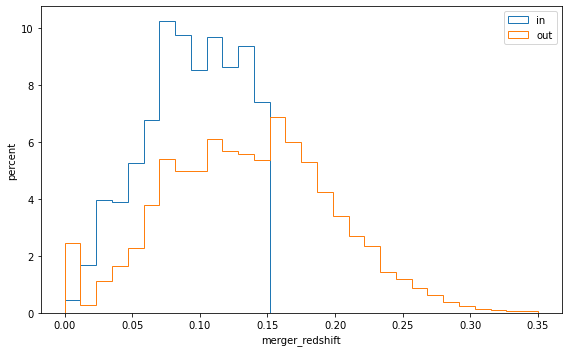

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(merger_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(merger_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("merger_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

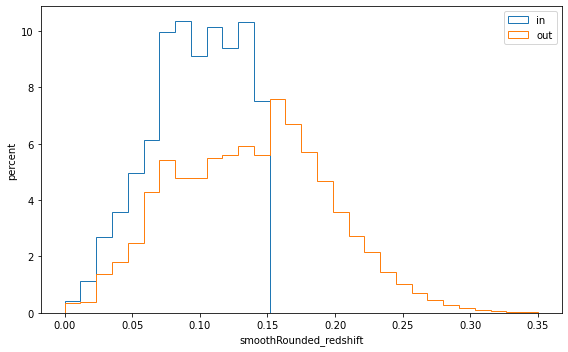

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(smoothRounded_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(smoothRounded_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("smoothRounded_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

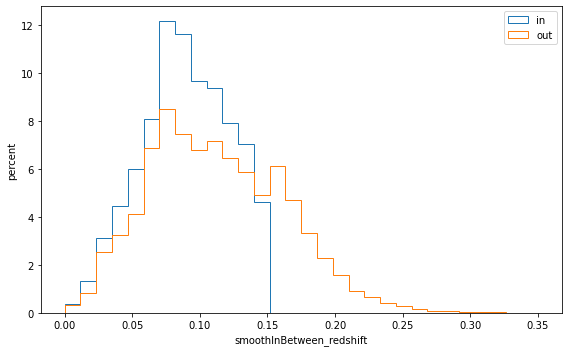

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(smoothInBetween_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(smoothInBetween_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("smoothInBetween_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

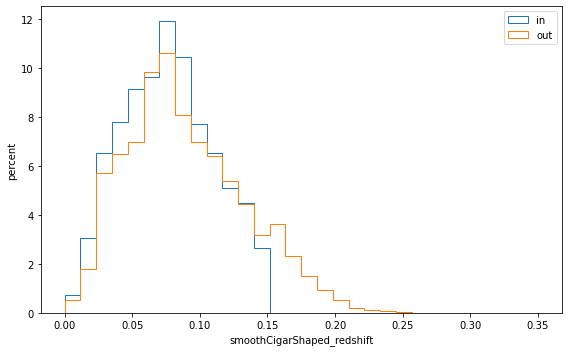

In [15]:
plt.figure(figsize=(8, 5))
plt.hist(smoothCigarShaped_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(smoothCigarShaped_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("smoothCigarShaped_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

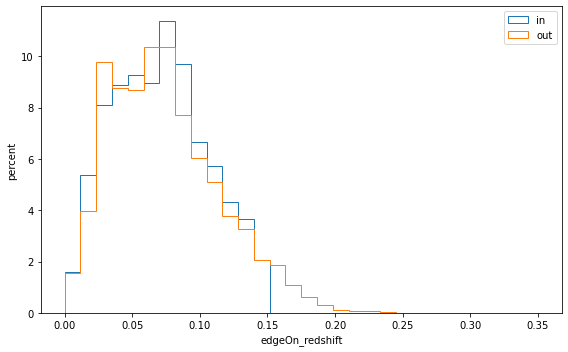

In [16]:
plt.figure(figsize=(8, 5))
plt.hist(edgeOn_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(edgeOn_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("edgeOn_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

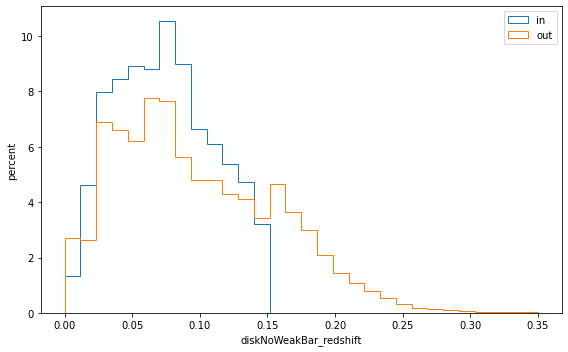

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(diskNoWeakBar_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(diskNoWeakBar_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("diskNoWeakBar_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

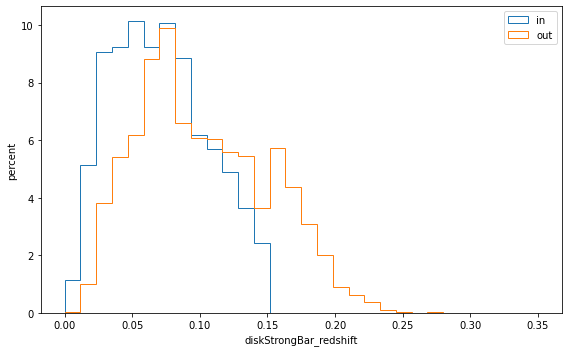

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(diskStrongBar_in.redshift,range=(1e-5,0.35), histtype="step", label = "in", bins=30,density=True)
plt.hist(diskStrongBar_out.z,range=(1e-5,0.35), histtype="step", label = "out", bins=30,density=True)
plt.xlabel("diskStrongBar_redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

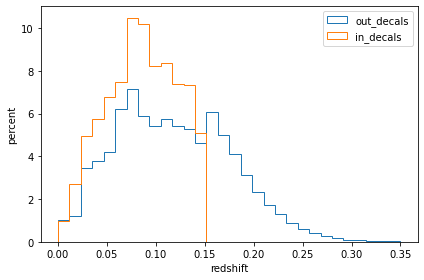

In [19]:
# plt.figure(figsize=(15, 10))
plt.hist(out.z,range=(1e-5,0.35), histtype="step", label = "out_decals", bins=30,density=True)
plt.hist(df_auto.redshift,range=(1e-5,0.35), histtype="step", label = "in_decals", bins=30,density=True)
plt.xlabel("redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

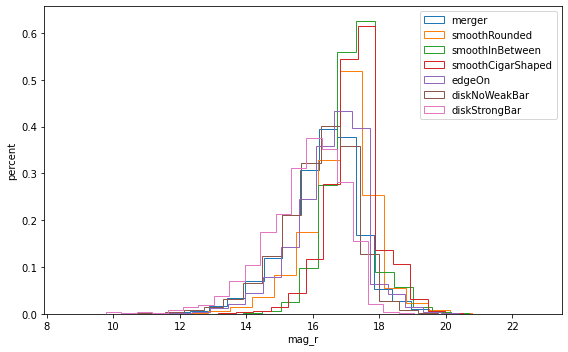

In [20]:
plt.figure(figsize=(8, 5))
plt.hist(merger_in.mag_r, histtype="step", label = "merger", bins=20,density=True)
plt.hist(smoothRounded_in.mag_r, histtype="step", label = "smoothRounded", bins=20,density=True)
plt.hist(smoothInBetween_in.mag_r, histtype="step", label = "smoothInBetween", bins=20,density=True)
plt.hist(smoothCigarShaped_in.mag_r, histtype="step", label = "smoothCigarShaped", bins=20,density=True)
plt.hist(edgeOn_in.mag_r, histtype="step", label = "edgeOn", bins=20,density=True)
diskNoWeakBar_plot = diskNoWeakBar_in.replace([np.inf, -np.inf], np.nan)
plt.hist(diskNoWeakBar_plot.mag_r, histtype="step", label = "diskNoWeakBar", bins=20,density=True)
plt.hist(diskStrongBar_in.mag_r, histtype="step", label = "diskStrongBar", bins=20,density=True)
plt.xlabel("mag_r")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

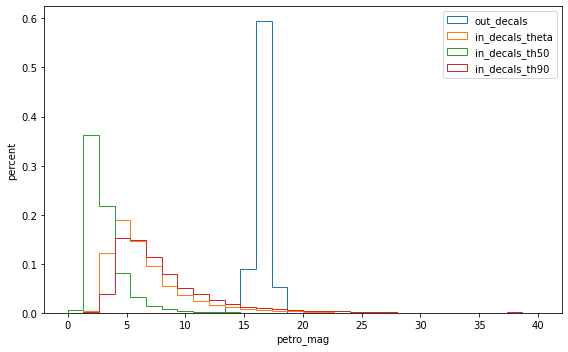

In [21]:
plt.figure(figsize=(8, 5))
plt.hist(out.petro_mag,range=(1e-5,40), histtype="step", label = "out_decals", bins=30,density=True)
plt.hist(df_auto.petro_theta,range=(1e-5,40), histtype="step", label = "in_decals_theta", bins=30,density=True)
plt.hist(df_auto.petro_th50,range=(1e-5,40), histtype="step", label = "in_decals_th50", bins=30,density=True)
plt.hist(df_auto.petro_th90,range=(1e-5,40), histtype="step", label = "in_decals_th90", bins=30,density=True)
plt.xlabel("petro_mag")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

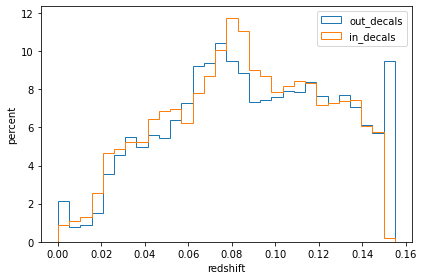

In [22]:
# plt.figure(figsize=(15, 10))
plt.hist(out.z,range=(1e-5,0.155), histtype="step", label = "out_decals", bins=30,density=True)
plt.hist(df_auto.redshift,range=(1e-5,0.155), histtype="step", label = "in_decals", bins=30,density=True)
plt.xlabel("redshift")
plt.ylabel("percent")
plt.legend(loc="best")
plt.tight_layout()

In [88]:
from tqdm import tqdm
ra = [str(i) for i in out.ra]
dec = [str(i) for i in out.dec]
for i in range(len(ra)):
    for j in range(1,5):
        if len(ra[i].split(".")[1]) == j:
            ra[i] += "0" * (5-j)
for i in range(len(dec)):
    for j in range(1,5):
        if len(dec[i].split(".")[1]) == j:
            dec[i] += "0" * (5-j)
z = list(out.z)
p = os.listdir("/data/renhaoye/decals_2022/out_decals/normalized_dat/")
full = []
short = []
for i in range(len(p)):
    x = p[i].split("_")[0]
    y = p[i].split("_")[1]
    full.append(str(x)+"_"+str(y))
    x = x.split(".")[0] + "." + x.split(".")[1][:resolution-1]
    y = y.split(".")[0] + "." + y.split(".")[1][:resolution-1]
    short.append(x + "_" + y)
for i in tqdm(range(len(z))):
# for i in tqdm(range(20)):
    if z[i]>0.15:
        query = short.index(str(ra[i]) + "_" + str(dec[i]))
        os.system("mv /data/renhaoye/decals_2022/out_decals/normalized_dat/%s /data/renhaoye/decals_2022/out_decals/zover015_dat/" % (full[query] + "_0.262_grz_raw.dat"))
        # print("mv /data/renhaoye/decals_2022/out_decals/normalized_dat/%s /data/renhaoye/decals_2022/out_decals/zover015_dat/" % (full[query] +"_0.262_grz_raw.dat"))

100%|█████████████████████████████████| 444220/444220 [7:29:06<00:00, 16.49it/s]
